In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

In [69]:
def coupon_payment_dates(single_bond_data_df, oldest_date):
    '''Take in a dataframe contianing the data for a single bond. Calculate all of the coupon payment dates starting at
       the maturity date, until the begining of the data frame'''
    
    maturity_date = pd.to_datetime(single_bond_data_df['Maturity'].iloc[0])
    payment_dates = [maturity_date]  #Get maturity date of bond
    num_payments_per_year = single_bond_data_df['Cpn Freq'].iloc[0]     #Get number of coup payments per year
    yrs_to_matur = (maturity_date - pd.to_datetime(oldest_date)).days / 365 #Calculate years to maturity
    num_payments = math.ceil(yrs_to_matur * num_payments_per_year)  #Calculate total number of payments
        
    payment_dates = pd.date_range(end=maturity_date, periods=num_payments, freq=f'{int(365/num_payments_per_year)}D')
        
    return payment_dates
    

In [70]:
def calc_single_bond_return(single_bond_data_df):
    '''Pass in the bond data for a single bond for every quarter it is in the investible universe. Calculate the return
       of the bond between quarters. Returns the weighted returns of the bond per quarter in percentages'''
    
    #Find the coupon payment dates for the bond 
    coupon_dates_all = coupon_payment_dates(single_bond_data_df, single_bond_data_df['Date'].iloc[0])
    
    
    all_quarter_returns = [0] * len(single_bond_data_df)
    for i in range(1, len(single_bond_data_df['Date'])):
        #Select the coup dates that occured this Quarter
        coupon_dates = coupon_dates_all[(coupon_dates_all <= pd.to_datetime(single_bond_data_df['Date'].iloc[i])) & (coupon_dates_all >= pd.to_datetime(single_bond_data_df['Date'].iloc[i-1]))]
        #Assume 100 face for coupon payments
        coupon_rate = (single_bond_data_df['Cpn'].iloc[0] / single_bond_data_df['Cpn Freq'].iloc[0]) / 100    #Want rate in decimal form
        coupon_cashflows = 100 * coupon_rate * len(coupon_dates)
        
        #Check if matures between quarters
        if (single_bond_data_df['Date'].iloc[i] >= single_bond_data_df['Maturity'].iloc[i-1]) and single_bond_data_df['Date'].iloc[i-1] <= single_bond_data_df['Maturity'].iloc[i-1]:
            total_proceeds = coupon_cashflows + 100      #100 is FV of the bond
            last_price = single_bond_data_df['Ask Price'].iloc[i-1]
            total_return = (total_proceeds - last_price) / last_price
            all_quarter_returns[i] = total_return
        
        else:
            current_price = single_bond_data_df['Bid Price'].iloc[i]
            last_price = single_bond_data_df['Ask Price'].iloc[i-1]
            total_proceeds = coupon_cashflows + current_price
            total_return = (total_proceeds - last_price) / last_price
            all_quarter_returns[i] = total_return

    single_bond_data_df['Returns'] = all_quarter_returns
    single_bond_data_df['Weighted Returns'] = single_bond_data_df['Returns'] * single_bond_data_df['Weights'].shift(1)
    single_bond_data_df['Weighted Returns'].iloc[0] = 0
    return single_bond_data_df 

In [71]:
def calc_single_bond_return_notransaction_costs(single_bond_data_df):
    '''Pass in the bond data for a single bond for every quarter it is in the investible universe. Calculate the return
       of the bond between quarters. Returns the weighted returns of the bond per quarter in percentages'''
    
    #Find the coupon payment dates for the bond 
    coupon_dates_all = coupon_payment_dates(single_bond_data_df, single_bond_data_df['Date'].iloc[0])
    
    
    all_quarter_returns = [0] * len(single_bond_data_df)
    for i in range(1, len(single_bond_data_df['Date'])):
        #Select the coup dates that occured this Quarter
        coupon_dates = coupon_dates_all[(coupon_dates_all <= pd.to_datetime(single_bond_data_df['Date'].iloc[i])) & (coupon_dates_all >= pd.to_datetime(single_bond_data_df['Date'].iloc[i-1]))]
        #Assume 100 face for coupon payments
        coupon_rate = (single_bond_data_df['Cpn'].iloc[0] / single_bond_data_df['Cpn Freq'].iloc[0]) / 100    #Want rate in decimal form
        coupon_cashflows = 100 * coupon_rate * len(coupon_dates)
        
        #Check if matures between quarters
        if (single_bond_data_df['Date'].iloc[i] >= single_bond_data_df['Maturity'].iloc[i-1]) and single_bond_data_df['Date'].iloc[i-1] <= single_bond_data_df['Maturity'].iloc[i-1]:
            total_proceeds = coupon_cashflows + 100      #100 is FV of the bond
            last_price = (single_bond_data_df['Ask Price'].iloc[i-1] + single_bond_data_df['Bid Price'].iloc[i-1]) / 2
            total_return = (total_proceeds - last_price) / last_price
            all_quarter_returns[i] = total_return
        
        else:
            current_price = (single_bond_data_df['Bid Price'].iloc[i] + single_bond_data_df['Ask Price'].iloc[i]) / 2
            last_price = (single_bond_data_df['Bid Price'].iloc[i-1] + single_bond_data_df['Ask Price'].iloc[i-1]) / 2
            total_proceeds = coupon_cashflows + current_price
            total_return = (total_proceeds - last_price) / last_price
            all_quarter_returns[i] = total_return

    single_bond_data_df['Returns'] = all_quarter_returns
    single_bond_data_df['Weighted Returns'] = single_bond_data_df['Returns'] * single_bond_data_df['Weights'].shift(1)
    single_bond_data_df['Weighted Returns'].iloc[0] = 0
    return single_bond_data_df 

In [72]:
def df_formatter(df):
    
    df_formatted = pd.DataFrame()
    df_formatted['Date'] = df['Date']
    df_formatted['CUSIP'] = df['CUSIP']
    df_formatted['Weights'] = df['Weights']
    
    # Replace NaN values in 'Returns' column with 0
    df_formatted['Returns'] = df['Returns'].fillna(0)
    
    # Calculate 'Weighted_Returns'
    df_formatted['Weighted_Returns'] = df['Weighted Returns']
    #df_formatted['Weighted_Returns'] = df_formatted['Weights'] * df_formatted['Returns']
    
    return df_formatted


In [73]:
def get_portcumret(Jim_df):
    # Create a list called "portret" with the value 1
    portret = [1]
    date = Jim_df['Date'].unique().tolist()
    
    
    # Break up the df by date
    for _, group in Jim_df.groupby('Date'):
        # For each date, sum the "Weighted_Ret" column
        sum_weighted_ret = group['Weighted_Returns'].sum()
        # Append each sum to the portret list
        portret.append(sum_weighted_ret)

    #Calculate cumulative return
    cum_ret = [(1 + portret[i]) * (1 + portret[i - 1]) - 1 for i in range(1, len(portret))]
    
    df = pd.DataFrame()
    df['Date'] = date
    df['Portfolio_cumulative_returns'] = cum_ret
    
    return df

In [74]:
master_bond_data = pd.read_csv('Bond Master - All Weights 04232024.csv')
master_bond_data['Date'] = pd.to_datetime(master_bond_data['Date'])
master_bond_data = master_bond_data.sort_values(by='Date')
master_bond_data['Maturity'] = pd.to_datetime(master_bond_data['Maturity'])
unique_cusip = master_bond_data['CUSIP'].unique()
#Select columns from existing dataframe
combined_returns_df = pd.DataFrame({
    'Date': [],
    'CUSIP': [],
    'Returns': [],  # Initialize a new column with no data
    'Weighted Returns': []
})

#Loop over each unique bond and calculate its quarterly returns
for i in range(0, len(unique_cusip)):
    cusip = unique_cusip[i]
    filtered_df = master_bond_data[master_bond_data['CUSIP'] == cusip]
    bond_returns = calc_single_bond_return(filtered_df)
    #Selecting only the necessary columns from bond_returns_df
    bond_returns_subset = bond_returns[['Date', 'CUSIP', 'Returns', 'Weighted Returns']]
    combined_returns_df = pd.concat([combined_returns_df, bond_returns_subset], ignore_index=True)

#master_bond_data['Returns'] = master_bond_data['CUSIP']
merged_df = pd.merge(master_bond_data, combined_returns_df, on=['Date', 'CUSIP'], how='left')
#merged_df = merged_df.drop(columns=['Returns_x'])
#merged_df = merged_df.rename(columns={'Returns_y': 'Returns'})

In [75]:
combined_returns_df.to_csv('combined_returns.csv', index=False)

In [76]:
merged_df.to_csv('All_Data_All_Dates_Returns_Included.csv', index=False)

In [77]:
#Insert File Path Here
filepath = 'All_Data_All_Dates_Returns_Included.csv'

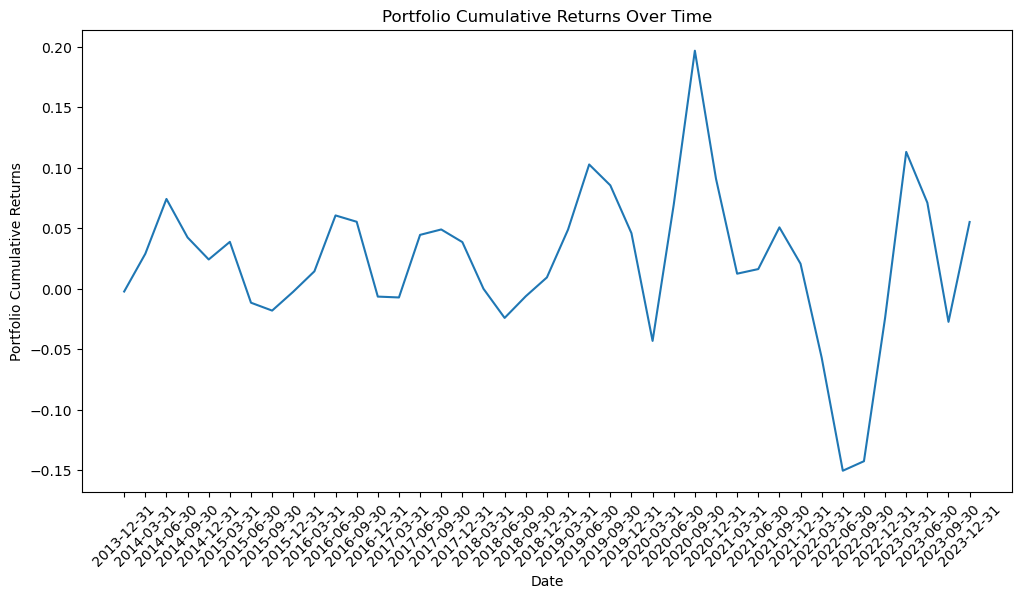

,Date,Portfolio_cumulative_returns
1,2013-12-31,-0.002380
2,2014-03-31,0.028856
3,2014-06-30,0.074205
4,2014-09-30,0.042346
5,2014-12-31,0.024126
6,2015-03-31,0.038702
7,2015-06-30,-0.011647
8,2015-09-30,-0.018160
9,2015-12-31,-0.002526
10,2016-03-31,0.014327


In [78]:
#Run this
testdf = pd.read_csv(filepath)
testdf_form = df_formatter(testdf)

# Example usage
cumulative_returns_df = get_portcumret(testdf_form)
cumulative_returns_df = cumulative_returns_df[1:]

x = cumulative_returns_df['Date']
y = cumulative_returns_df['Portfolio_cumulative_returns']

plt.figure(figsize=(12, 6))
plt.plot(x, y)
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Portfolio Cumulative Returns')
plt.title('Portfolio Cumulative Returns Over Time')
plt.show()
cumulative_returns_df

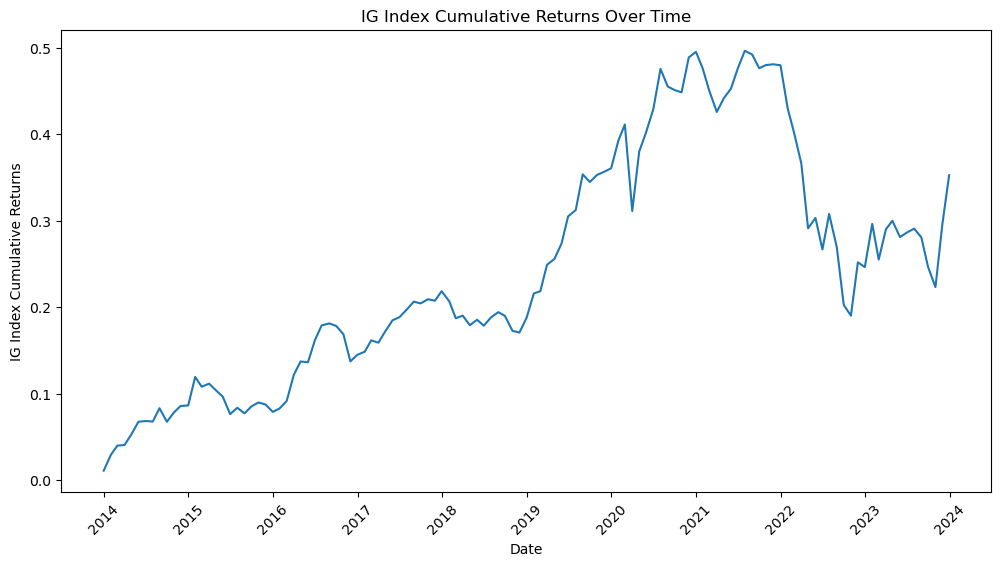

In [79]:
IG_index_df = pd.read_excel('LUACTRUU Index.xlsx')
IG_index_df['Date'] = pd.to_datetime(IG_index_df['Date'])
IG_index_df = IG_index_df.sort_values(by='Date')
IG_index_df = IG_index_df[(IG_index_df['Date'] >= '2013-09-30') & (IG_index_df['Date'] <= '2023-12-31')]
IG_index_df['Returns'] = IG_index_df['Price'].pct_change()
IG_index_df['Cumulative_Returns'] = (1 + IG_index_df['Returns']).cumprod() - 1
IG_index_df['Cumulative_Returns'] = IG_index_df['Cumulative_Returns']

x_IG = IG_index_df['Date'].iloc[3:]
y_IG = IG_index_df['Cumulative_Returns'].iloc[3:]

plt.figure(figsize=(12, 6))
plt.plot(x_IG, y_IG)
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('IG Index Cumulative Returns')
plt.title('IG Index Cumulative Returns Over Time')
plt.show()

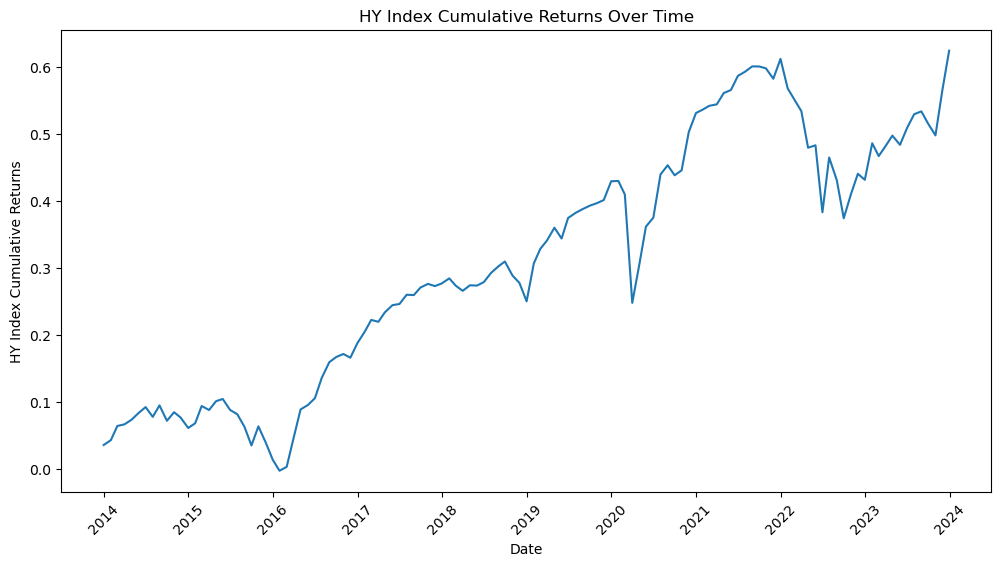

In [80]:
HY_index_df = pd.read_excel('LF98TRUU Index.xlsx')
HY_index_df['Date'] = pd.to_datetime(HY_index_df['Date'])
HY_index_df = HY_index_df.sort_values(by='Date')
HY_index_df = HY_index_df[(HY_index_df['Date'] >= '2013-09-30') & (HY_index_df['Date'] <= '2023-12-31')]
HY_index_df['Returns'] = HY_index_df['Price'].pct_change()
HY_index_df['Cumulative_Returns'] = (1 + HY_index_df['Returns']).cumprod() - 1
HY_index_df['Cumulative_Returns'] = HY_index_df['Cumulative_Returns']

x_HY = HY_index_df['Date'].iloc[3:]
y_HY = HY_index_df['Cumulative_Returns'].iloc[3:]

plt.figure(figsize=(12, 6))
plt.plot(x_HY, y_HY)
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('HY Index Cumulative Returns')
plt.title('HY Index Cumulative Returns Over Time')
plt.show()

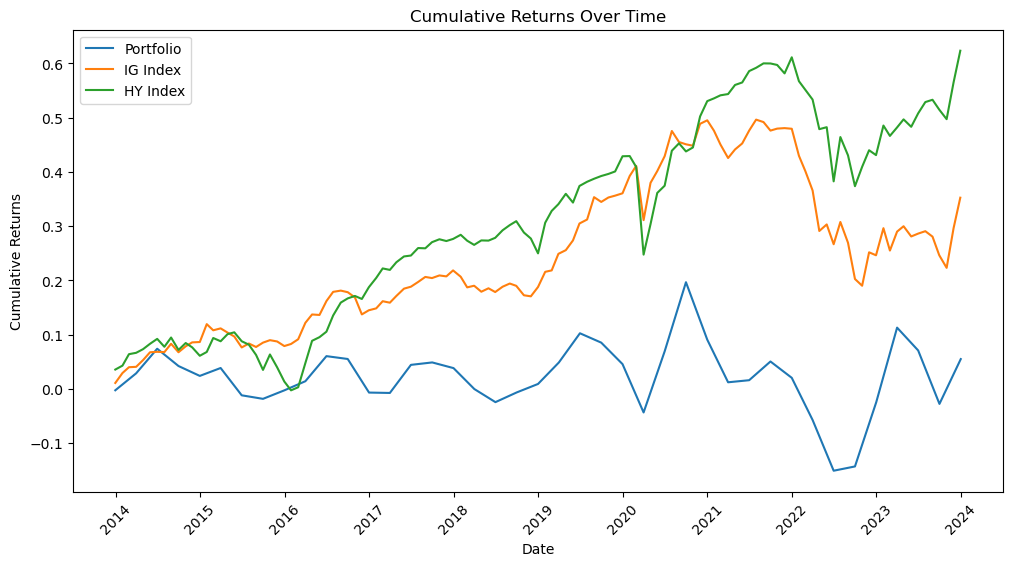

In [81]:
x = cumulative_returns_df['Date']
x = pd.to_datetime(cumulative_returns_df['Date'])
y = cumulative_returns_df['Portfolio_cumulative_returns']

x_IG = IG_index_df['Date'].iloc[3:].reset_index(drop=True)
x_IG = pd.to_datetime(IG_index_df['Date'].iloc[3:])
y_IG = IG_index_df['Cumulative_Returns'].iloc[3:].reset_index(drop=True)

x_HY = HY_index_df['Date'].iloc[3:].reset_index(drop=True)
x_HY = pd.to_datetime(HY_index_df['Date'].iloc[3:])
y_HY = HY_index_df['Cumulative_Returns'].iloc[3:].reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.plot(x, y, label='Portfolio')
plt.plot(x_IG, y_IG, label='IG Index')
plt.plot(x_HY, y_HY, label='HY Index')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.show()

# NO TRANSACTION COSTS (Mid Prices)

In [82]:
master_bond_data = pd.read_csv('Bond Master - All Weights 04232024.csv')
master_bond_data['Date'] = pd.to_datetime(master_bond_data['Date'])
master_bond_data = master_bond_data.sort_values(by='Date')
master_bond_data['Maturity'] = pd.to_datetime(master_bond_data['Maturity'])
unique_cusip = master_bond_data['CUSIP'].unique()
#Select columns from existing dataframe
combined_returns_df = pd.DataFrame({
    'Date': [],
    'CUSIP': [],
    'Returns': [],  # Initialize a new column with no data
    'Weighted Returns': []
})

#Loop over each unique bond and calculate its quarterly returns
for i in range(0, len(unique_cusip)):
    cusip = unique_cusip[i]
    filtered_df = master_bond_data[master_bond_data['CUSIP'] == cusip]
    bond_returns = calc_single_bond_return_notransaction_costs(filtered_df)
    #Selecting only the necessary columns from bond_returns_df
    bond_returns_subset = bond_returns[['Date', 'CUSIP', 'Returns', 'Weighted Returns']]
    combined_returns_df = pd.concat([combined_returns_df, bond_returns_subset], ignore_index=True)

#master_bond_data['Returns'] = master_bond_data['CUSIP']
merged_df = pd.merge(master_bond_data, combined_returns_df, on=['Date', 'CUSIP'], how='left')

In [83]:
merged_df.to_csv('All_Data_No_Transaction_Costs.csv', index=False)

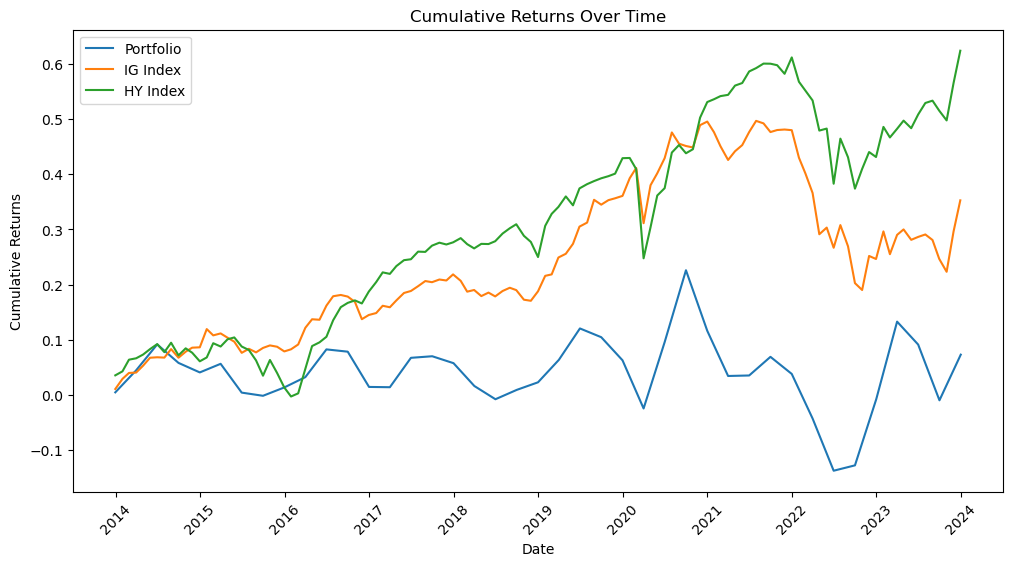

In [84]:
#Insert File Path Here
filepath = 'All_Data_No_Transaction_Costs.csv'

#Run this
testdf = pd.read_csv(filepath)
testdf_form = df_formatter(testdf)

# Example usage
cumulative_returns_notransaction_df = get_portcumret(testdf_form)
cumulative_returns_notransaction_df = cumulative_returns_notransaction_df[1:]

IG_index_df = pd.read_excel('LUACTRUU Index.xlsx')
IG_index_df['Date'] = pd.to_datetime(IG_index_df['Date'])
IG_index_df = IG_index_df.sort_values(by='Date')
IG_index_df = IG_index_df[(IG_index_df['Date'] >= '2013-09-30') & (IG_index_df['Date'] <= '2023-12-31')]
IG_index_df['Returns'] = IG_index_df['Price'].pct_change()
IG_index_df['Cumulative_Returns'] = (1 + IG_index_df['Returns']).cumprod() - 1
IG_index_df['Cumulative_Returns'] = IG_index_df['Cumulative_Returns']

HY_index_df = pd.read_excel('LF98TRUU Index.xlsx')
HY_index_df['Date'] = pd.to_datetime(HY_index_df['Date'])
HY_index_df = HY_index_df.sort_values(by='Date')
HY_index_df = HY_index_df[(HY_index_df['Date'] >= '2013-09-30') & (HY_index_df['Date'] <= '2023-12-31')]
HY_index_df['Returns'] = HY_index_df['Price'].pct_change()
HY_index_df['Cumulative_Returns'] = (1 + HY_index_df['Returns']).cumprod() - 1
HY_index_df['Cumulative_Returns'] = HY_index_df['Cumulative_Returns']

x = cumulative_returns_notransaction_df['Date']
x = pd.to_datetime(cumulative_returns_notransaction_df['Date'])
y = cumulative_returns_notransaction_df['Portfolio_cumulative_returns']

x_IG = IG_index_df['Date'].iloc[3:].reset_index(drop=True)
x_IG = pd.to_datetime(IG_index_df['Date'].iloc[3:])
y_IG = IG_index_df['Cumulative_Returns'].iloc[3:].reset_index(drop=True)

x_HY = HY_index_df['Date'].iloc[3:].reset_index(drop=True)
x_HY = pd.to_datetime(HY_index_df['Date'].iloc[3:])
y_HY = HY_index_df['Cumulative_Returns'].iloc[3:].reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.plot(x, y, label='Portfolio')
plt.plot(x_IG, y_IG, label='IG Index')
plt.plot(x_HY, y_HY, label='HY Index')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.show()

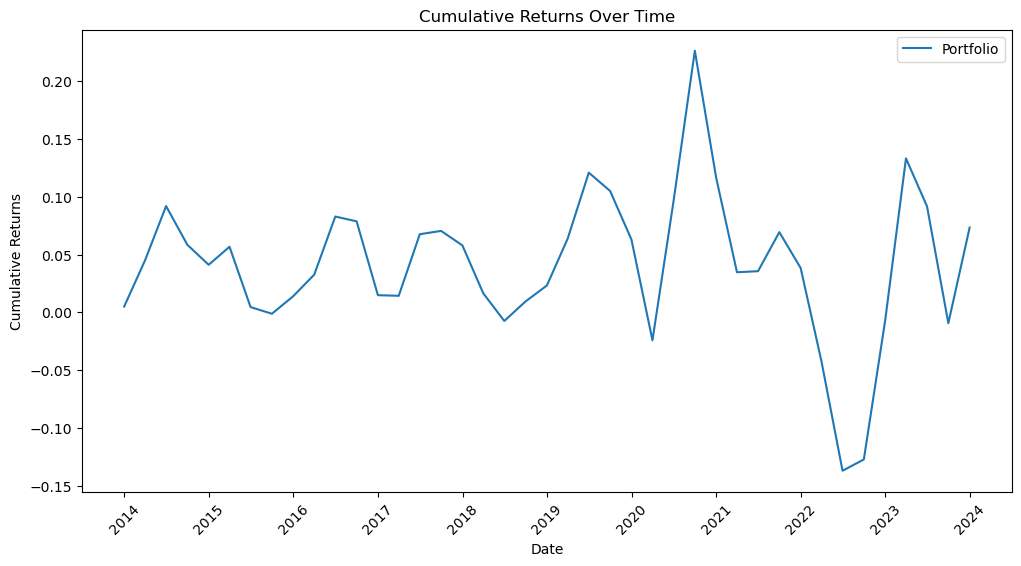

In [85]:
plt.figure(figsize=(12, 6))
plt.plot(x, y, label='Portfolio')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.show()

In [86]:
cumulative_returns_notransaction_df

,Date,Portfolio_cumulative_returns
1,2013-12-31,0.005028
2,2014-03-31,0.044895
3,2014-06-30,0.091852
4,2014-09-30,0.058358
5,2014-12-31,0.041121
6,2015-03-31,0.056703
7,2015-06-30,0.004555
8,2015-09-30,-0.001197
9,2015-12-31,0.013923
10,2016-03-31,0.032610
